In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
import seaborn as sns
sns.set()

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submit.csv', header = None)

In [4]:
train = train.drop(columns = ['id'])
test = test.drop(columns = ['id'])

train["AG_ratio"].fillna(train["Alb"] / (train["TP"] - train["Alb"]), inplace=True)
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)

test["AG_ratio"].fillna(test["Alb"] / (test["TP"] - test["Alb"]), inplace=True)
test.drop_duplicates(inplace=True)
test.reset_index(drop=True, inplace=True)

train["GLO"] = (train["TP"] - train["Alb"])
test["GLO"] = (test["TP"] - test["Alb"])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       891 non-null    int64  
 1   Gender    891 non-null    object 
 2   T_Bil     891 non-null    float64
 3   D_Bil     891 non-null    float64
 4   ALP       891 non-null    float64
 5   ALT_GPT   891 non-null    float64
 6   AST_GOT   891 non-null    float64
 7   TP        891 non-null    float64
 8   Alb       891 non-null    float64
 9   AG_ratio  891 non-null    float64
 10  disease   891 non-null    int64  
 11  GLO       891 non-null    float64
dtypes: float64(9), int64(2), object(1)
memory usage: 83.7+ KB


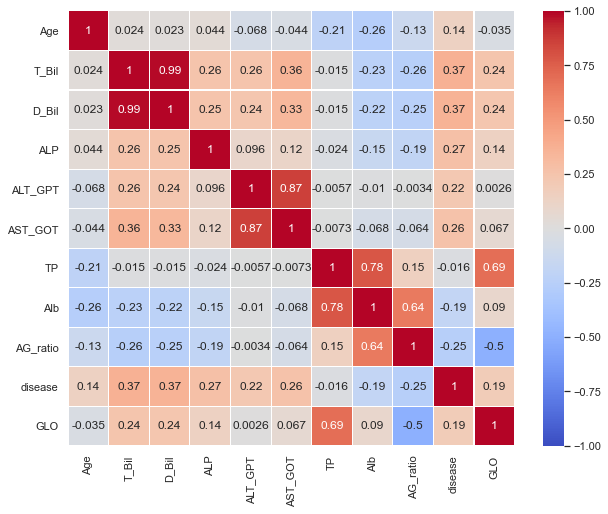

In [6]:
# heatmapの表示
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [7]:
train["Gender"] = train["Gender"].apply(lambda x: 1 if x=="Male" else 0)
test["Gender"] = test["Gender"].apply(lambda x: 1 if x=="Male" else 0)

In [8]:
X_train = train[['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio' ]]
y = train["disease"]
X_train_target = X_train

X_test_target = test[['Age', 'Gender', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio']]

In [9]:
X_train_target.describe()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,43.340067,0.767677,2.807856,1.256790,268.607071,63.770146,81.336139,6.537823,3.230752,0.998036
std,16.647096,0.422551,4.922115,2.578286,226.134887,154.295258,175.539331,1.030673,0.748239,0.302349
min,3.000000,0.000000,0.400000,0.100000,63.000000,9.900000,10.100000,2.600000,0.900000,0.310000
25%,31.000000,1.000000,0.800000,0.200000,170.450000,21.900000,22.900000,5.900000,2.700000,0.810000
50%,44.000000,1.000000,1.100000,0.400000,198.000000,30.000000,35.000000,6.600000,3.200000,0.990000
75%,57.000000,1.000000,2.100000,0.900000,279.000000,51.400000,68.000000,7.300000,3.800000,1.168333
max,90.000000,1.000000,43.200000,19.800000,2110.100000,2000.200000,2946.000000,9.600000,5.600000,2.970000


In [10]:
X_test_target.describe()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,42.942408,0.751309,2.842408,1.075654,251.396073,71.764660,87.207592,6.490576,3.230890,1.006885
std,16.371245,0.432821,7.029998,2.282263,169.904503,180.246444,222.277722,1.040904,0.818352,0.307500
min,7.000000,0.000000,0.200000,0.100000,91.900000,9.800000,12.000000,3.500000,0.900000,0.100000
25%,30.000000,1.000000,0.800000,0.200000,171.175000,21.900000,23.100000,5.900000,2.625000,0.810000
50%,42.000000,1.000000,1.100000,0.300000,194.900000,31.050000,35.050000,6.500000,3.250000,1.000000
75%,55.000000,1.000000,1.900000,0.800000,275.775000,52.000000,61.725000,7.200000,3.800000,1.190000
max,84.000000,1.000000,75.300000,19.800000,1580.000000,1999.900000,2946.000000,9.600000,5.600000,2.380000


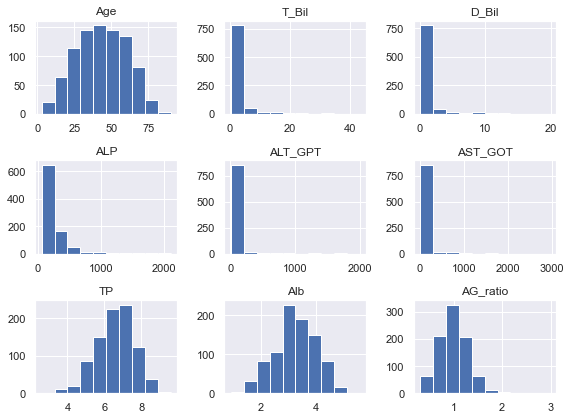

In [11]:
col_category = ['Gender', 'disease',  'GLO']
df_numeric = train.drop(col_category, axis = 1)
df_numeric.head()

df_numeric.hist(figsize = (8, 6))
plt.tight_layout()
plt.show()

In [12]:
# 境界値を指定したAgeのbin分割
bins_Age = [0, 25, 55, 100]
X_train_cut, bin_indice = pd.cut(X_train_target["Age"], bins=bins_Age, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["Age"], bins=bins_Age, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したT_Bilのbin分割
bins_T_Bil = [0, 0.5, 1.0, 100]
X_train_cut, bin_indice = pd.cut(X_train_target["T_Bil"], bins=bins_T_Bil, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["T_Bil"], bins=bins_T_Bil, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したAST_GOTのbin分割
bins_AST = [0, 25, 50, 3000]
X_train_cut, bin_indice = pd.cut(X_train_target["AST_GOT"], bins=bins_AST, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["AST_GOT"], bins=bins_AST, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したALPのbin分割
bins_ALP = [0, 100, 200, 2500]
X_train_cut, bin_indice = pd.cut(X_train_target["ALP"], bins=bins_ALP, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["ALP"], bins=bins_ALP, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したAlbのbin分割
bins_Alb = [0, 2.0,  4.0, 6.0]
X_train_cut, bin_indice = pd.cut(X_train_target["Alb"], bins=bins_Alb, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["Alb"], bins=bins_Alb, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したTPのbin分割
bins_TP = [0, 2.5,  5.0, 7.5, 10.0]
X_train_cut, bin_indice = pd.cut(X_train_target["TP"], bins=bins_TP, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["TP"], bins=bins_TP, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


# 境界値を指定したAG_ratioのbin分割
bins_AG_ratio = [0, 0.5,  1.0, 3.0]
X_train_cut, bin_indice = pd.cut(X_train_target["AG_ratio"], bins=bins_AG_ratio, retbins=True, labels=False)
X_train_dummies = pd.get_dummies(X_train_cut, prefix=X_train_cut.name)
X_train_binned = pd.concat([X_train_target, X_train_dummies], axis=1)

X_test_cut, bin_indice = pd.cut(X_test_target["AG_ratio"], bins=bins_AG_ratio, retbins=True, labels=False)
X_test_dummies = pd.get_dummies(X_test_cut, prefix=X_test_cut.name)
X_test_binned = pd.concat([X_test_target, X_test_dummies], axis=1)

X_train_target = X_train_binned
X_test_target = X_test_binned


In [13]:
X_train_target

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,...,ALP_2,Alb_0,Alb_1,Alb_2,TP_1,TP_2,TP_3,AG_ratio_0,AG_ratio_1,AG_ratio_2
0,60,1,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,...,0,0,1,0,0,1,0,0,0,1
1,28,0,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,...,0,0,1,0,0,1,0,0,0,1
2,60,1,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,...,1,0,1,0,0,1,0,0,1,0
3,20,1,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,...,1,0,1,0,0,1,0,0,0,1
4,44,0,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,31,1,0.7,0.3,164.2,30.0,29.0,6.2,3.0,1.07,...,0,0,1,0,0,1,0,0,0,1
887,57,0,1.0,0.3,130.1,23.9,25.0,6.9,4.1,1.28,...,0,0,0,1,0,1,0,0,0,1
888,54,0,23.5,12.7,574.0,43.1,47.0,7.2,3.4,0.84,...,1,0,1,0,0,1,0,0,1,0
889,24,1,1.2,0.4,130.0,23.2,42.0,8.1,3.9,0.87,...,0,0,1,0,0,0,1,0,1,0


In [14]:
X_test_target

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,...,ALP_2,Alb_0,Alb_1,Alb_2,TP_1,TP_2,TP_3,AG_ratio_0,AG_ratio_1,AG_ratio_2
0,65,0,0.7,0.2,162.0,24.0,20.0,6.4,3.3,0.93,...,0,0,1,0,0,1,0,0,1,0
1,46,1,1.2,0.3,265.1,40.0,28.0,7.9,3.8,0.94,...,1,0,1,0,0,0,1,0,1,0
2,26,1,0.7,0.1,243.1,21.1,22.9,5.3,2.2,0.60,...,1,0,1,0,0,1,0,0,1,0
3,38,1,3.5,1.7,253.0,80.0,406.0,6.8,3.7,1.33,...,1,0,1,0,0,1,0,0,0,1
4,46,0,0.7,0.2,236.0,10.1,13.0,6.8,3.0,0.74,...,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,37,1,1.0,0.4,243.1,50.1,101.0,7.1,3.8,1.18,...,1,0,1,0,0,1,0,0,0,1
378,46,1,0.8,0.2,179.1,20.0,57.1,6.5,3.4,1.29,...,0,0,1,0,0,1,0,0,0,1
379,47,1,0.8,0.3,326.1,28.8,17.1,8.7,5.6,1.67,...,1,0,0,1,0,0,1,0,0,1
380,42,0,0.9,0.1,165.1,27.0,29.0,8.5,4.4,1.05,...,0,0,0,1,0,0,1,0,0,1


In [15]:
# 多項式・交互作用特徴量(train)
polynomial = PolynomialFeatures(degree=2, include_bias=False)
polynomial_arr = polynomial.fit_transform(X_train_target)
X_train_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

# 多項式・交互作用特徴量(test)
polynomial = PolynomialFeatures(degree=2, include_bias=False)
polynomial_arr = polynomial.fit_transform(X_test_target)
X_test_polynomial = pd.DataFrame(polynomial_arr, columns=["poly" + str(x) for x in range(polynomial_arr.shape[1])])

In [16]:
# 組み込み法のモデル、閾値の指定
fs_model = LogisticRegression(penalty='l2', random_state=0)
fs_threshold = "mean"
# 組み込み法モデルの初期化
selector = SelectFromModel(fs_model, threshold=fs_threshold)

In [17]:
# 特徴量選択の実行
selector.fit(X_train_polynomial, y)
mask = selector.get_support()

/Users/Takayasu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
# 選択された特徴量だけのサンプル取得
X_train_polynomial_masked = X_train_polynomial.loc[:, mask]

# 選択された特徴量だけのサンプル取得
X_test_polynomial_masked = X_test_polynomial.loc[:, mask]

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [20]:
# モデルの学習・予測
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train_polynomial_masked, y)
y_train_pred = model.predict_proba(X_train_polynomial_masked )[:, 1]
y_test_pred = model.predict_proba(X_test_polynomial_masked )[:, 1]

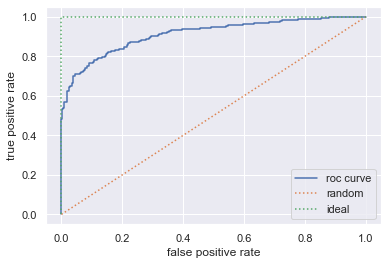

In [21]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_train_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [22]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y, y_score=y_train_pred)
print("AUC:", auc_score)

AUC: 0.9118884293352163


In [25]:
# RandomForestによる分類
X_train, X_test, y_train, y_test = train_test_split(X_train_polynomial_masked, y, random_state = 0)

forest = RandomForestClassifier(n_estimators=100, random_state = 0)
forest.fit(X_train, y_train)
y_rand_pred = forest.predict_proba(X_train_polynomial_masked )[:, 1]
y_rand_pred_test = forest.predict_proba(X_test_polynomial_masked )[:, 1]

print(len(y_rand_pred))
print(len(y))

891
891


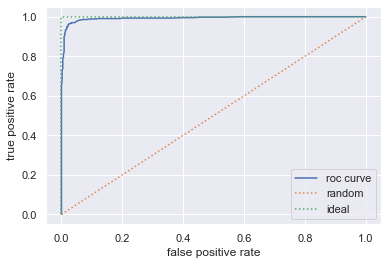

In [26]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_rand_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


In [27]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y, y_score=y_rand_pred)
print("AUC:", auc_score)

AUC: 0.9925274891556541


In [28]:
print("training set : {:.3f}".format(forest.score(X_train, y_train)))

training set : 1.000


In [29]:
print(len(y_rand_pred_test))

382


In [60]:
sample[1] = y_rand_pred_test
# sample.to_csv("RF4.csv", index = None, header = None)

In [38]:
#グリッドサーチの範囲を指定
parameters = {
     'n_estimators'      : [5, 10, 20, 30, 50, 100],
      'max_features'      : [3, 5, 10, 15, 20, 30, 50],
      'random_state'      : [3],
      'n_jobs'            : [1],
      'min_samples_split' : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
      'max_depth'         : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
 }
#交差検証+グリッドサーチにより最良パラメータの検索
rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, parameters, cv=3)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
                         'max_features': [3, 5, 10, 15, 20, 30, 50],
                         'min_samples_split': [3, 5, 10, 15, 20, 25, 30, 40, 50,
                                               100],
                         'n_estimators': [5, 10, 20, 30, 50, 100],
                         'n_jobs': [1], 'random_state': [3]})

In [39]:
print("最良パラメータ: {}".format(rfc_cv.best_params_))
print("最良交差検証スコア: {:.2f}".format(rfc_cv.best_score_))

最良パラメータ: {'max_depth': 20, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 100, 'n_jobs': 1, 'random_state': 3}
最良交差検証スコア: 0.86


In [40]:
# 上記結果により、ハイパーパラメータのチューニングを行う。
rfc_aft_cv = RandomForestClassifier(max_depth =20, max_features = 3, min_samples_split = 3, n_estimators = 100, n_jobs = 1, random_state = 3)
rfc_aft_cv.fit(X_train, y_train)

y_rfc_aft_pred = rfc_aft_cv.predict_proba(X_train_polynomial_masked )[:, 1]
y_rfc_pred_aft_test = rfc_aft_cv.predict_proba(X_test_polynomial_masked )[:, 1]

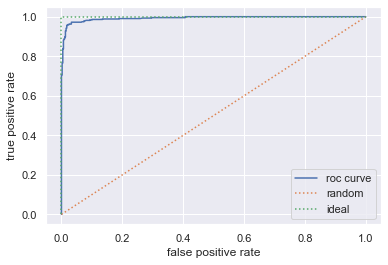

In [41]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_rfc_aft_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [42]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y, y_score=y_rfc_aft_pred)
print("AUC:", auc_score)
print("training set : {:.3f}".format(rfc_aft_cv.score(X_train, y_train)))
print("test set : {:.3f}".format(rfc_aft_cv.score(X_test, y_test)))
print("pre:AUC: 0.8830697282335117")
print("pre(max_depth = 5) training set :0.809")
print("pre(max_depth = 5) test set :0.780")

AUC: 0.9927418541309392
training set : 1.000
test set : 0.879
pre:AUC: 0.8830697282335117
pre(max_depth = 5) training set :0.809
pre(max_depth = 5) test set :0.780


In [43]:
scores = cross_val_score(rfc_aft_cv, X_train, y_train, cv=kf)
print(scores)

scores_mean = scores.mean()
print("平均スコア: {:.2f}".format(scores_mean))

[0.87313433 0.88059701 0.89552239 0.87969925 0.85714286]
平均スコア: 0.88


In [44]:
print("training set : {:.3f}".format(rfc_aft_cv.score(X_train, y_train)))

training set : 1.000


In [45]:
print(len(y_rfc_pred_aft_test))

382


In [46]:
sample[1] = y_rfc_pred_aft_test
sample.to_csv("RF_aft_CV2.csv", index = None, header = None)

In [47]:
#グリッドサーチの範囲を指定
parameters = {
     "n_estimators":[i for i in range(10,100,10)],
     "learning_rate":[0.01],
     "criterion":["friedman_mse"],
     "max_depth":[i for i in range(1,10,1)],
     "min_samples_split": [2,4,5,10,12,16, 20, 25, 50],
     "random_state":[3],
 }
#交差検証+グリッドサーチにより最良パラメータの検索
gbrt_cv = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5)
gbrt_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.01],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 4, 5, 10, 12, 16, 20, 25, 50],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'random_state': [3]})

In [48]:
print("最良パラメータ: {}".format(gbrt_cv.best_params_))
print("最良交差検証スコア: {:.2f}".format(gbrt_cv.best_score_))

最良パラメータ: {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 80, 'random_state': 3}
最良交差検証スコア: 0.84


In [49]:
# 上記結果により、ハイパーパラメータのチューニングを行う。
gbrt_aft_cv = GradientBoostingClassifier(criterion="friedman_mse", max_depth=8, min_samples_split=16, 
                                                         n_estimators=80, learning_rate=0.01, random_state=3)
gbrt_aft_cv.fit(X_train, y_train)

y_gbrt_aft_pred = gbrt_aft_cv.predict_proba(X_train_polynomial_masked )[:, 1]
y_gbrt_pred_aft_test = gbrt_aft_cv.predict_proba(X_test_polynomial_masked )[:, 1]

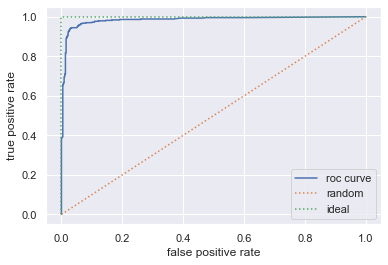

In [50]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_gbrt_aft_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [51]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y, y_score=y_gbrt_aft_pred)
print("AUC:", auc_score)
print("training set : {:.3f}".format(gbrt_aft_cv.score(X_train, y_train)))
print("test set : {:.3f}".format(gbrt_aft_cv.score(X_test, y_test)))
print("pre:AUC: 0.8830697282335117")
print("pre(max_depth = 5) training set :0.809")
print("pre(max_depth = 5) test set :0.780")

AUC: 0.9837511348733985
training set : 0.993
test set : 0.843
pre:AUC: 0.8830697282335117
pre(max_depth = 5) training set :0.809
pre(max_depth = 5) test set :0.780


In [52]:
scores = cross_val_score(gbrt_aft_cv, X_train, y_train, cv=kf)
print(scores)

scores_mean = scores.mean()
print("平均スコア: {:.2f}".format(scores_mean))

[0.84328358 0.87313433 0.85074627 0.84962406 0.85714286]
平均スコア: 0.85
